# Task dealing with imbalance data and improve performance

## load data


In [2]:
from transformers import AutoTokenizer, AutoModel
import spacy
import pandas as pd
import numpy as np
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
data=pd.read_csv('data_remove_punctuation.csv')

# After remove.
# vectorization=[]
# for i in data["symptoms"]:
#     bert_none_se_padding=tokenizer.encode(
#         text=i,
#         add_special_tokens=Ture,
#         pad_to_max_length = True,return_attention_mask = True
#     )
#     vectorization.append(bert_none_se_padding)

# data=pd.read_csv('data_remove_punctuation.csv')
input_ids=[]
attention_masks=[]

for msg in data["symptoms"]:
    bert_inp=tokenizer.encode_plus(msg,add_special_tokens = False,max_length =610,padding='max_length',return_attention_mask = True)#,return_tensors='pt'
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)

'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /emilyalsentzer/Bio_ClinicalBERT/resolve/main/tokenizer_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000176C6C5E610>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT/resolve/main/tokenizer_config.json
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /emilyalsentzer/Bio_ClinicalBERT/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000176C6C5E9A0>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT/resolve/main/config.json
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /emilyalsentzer/Bio_ClinicalBERT/resolve/main/tokenizer_conf

In [3]:
data['symptoms']= input_ids
data

,subject_id,hadm_id,admission_type,age,BMI,symptoms,target
0,10467237,20000019,5,76,25.366667,177,0
1,10467237,27923538,5,76,25.366667,177,1
2,16925328,20000024,5,84,27.069355,1425,0
3,16925328,21837264,5,84,27.069355,1202,0
4,16925328,21895449,4,84,27.069355,188,0
...,...,...,...,...,...,...,...
338670,16832788,29998928,6,78,28.485714,177,1
338671,19128791,29998991,4,34,28.000000,6272,0
338672,13467099,29999012,5,26,23.700000,12104,0
338673,19435486,29999301,8,38,30.729412,9386,0


## first use logistic regression


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

# Load the dataset
dataset = data

# Select the relevant columns
X = dataset[['admission_type', 'age', 'BMI', 'symptoms']].values
y = dataset['target'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a pipeline with MinMaxScaler and Logistic Regression with regularization
pipeline = make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l2'))

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      1.00      0.88     80256
           1       0.00      0.00      0.00     21347

    accuracy                           0.79    101603
   macro avg       0.39      0.50      0.44    101603
weighted avg       0.62      0.79      0.70    101603



d:\anacondanew\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anacondanew\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anacondanew\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Low performance at 1, as our target is to prepare for the patiences who length of stay >14

### we can see that the data is imbalance

In [3]:
import pandas as pd

# Assuming your dataset is stored in a pandas DataFrame called 'df'
num_zeros = data['target'].value_counts()
num_zeros

0    267258
1     71417
Name: target, dtype: int64

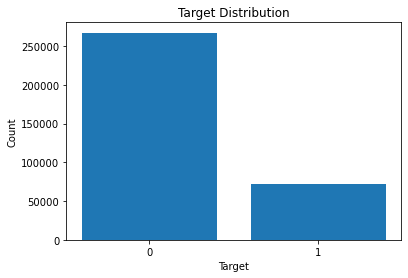

In [15]:
import matplotlib.pyplot as plt

target_counts = [267258, 71417]
target_labels = ['0', '1']

plt.bar(target_labels, target_counts)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Distribution')

plt.show()


## Random oversampling

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
dataset2 = data

# Select the relevant columns
X = dataset2[['admission_type', 'age', 'BMI', 'symptoms']].values
y = dataset2['target'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply oversampling to the training set
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model
model = LogisticRegression(penalty='l2')

# Train the model with the resampled and scaled data
model.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.54      0.66     80256
           1       0.27      0.64      0.38     21347

    accuracy                           0.56    101603
   macro avg       0.56      0.59      0.52    101603
weighted avg       0.73      0.56      0.60    101603



In [8]:
## smote
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
dataset3 = data

# Select the relevant columns
X = dataset3[['admission_type', 'age', 'BMI', 'symptoms']].values
y = dataset3['target'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE oversampling to the training set
oversampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model
model = LogisticRegression(penalty='l2')

# Train the model with the resampled and scaled data
model.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.54      0.66     80256
           1       0.27      0.64      0.38     21347

    accuracy                           0.56    101603
   macro avg       0.56      0.59      0.52    101603
weighted avg       0.73      0.56      0.60    101603



## Undersampling

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
dataset = data

# Select the relevant columns
X = dataset[['admission_type', 'age', 'BMI', 'symptoms']].values
y = dataset['target'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply under-sampling to the training set
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model
model = LogisticRegression(penalty='l2')

# Train the model with the resampled and scaled data
model.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.54      0.66     80256
           1       0.27      0.64      0.38     21347

    accuracy                           0.56    101603
   macro avg       0.56      0.59      0.52    101603
weighted avg       0.73      0.56      0.60    101603



In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
dataset = data

# Select the relevant columns
X = dataset[['admission_type', 'age', 'BMI', 'symptoms']].values
y = dataset['target'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the generator network
generator = Sequential()
generator.add(Dense(16, input_dim=X_train_scaled.shape[1], activation='relu'))
generator.add(Dense(8, activation='relu'))
generator.add(Dense(X_train_scaled.shape[1], activation='linear'))

# Define the discriminator network
discriminator = Sequential()
discriminator.add(Dense(8, input_dim=X_train_scaled.shape[1], activation='relu'))
discriminator.add(Dense(4, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

# Compile the discriminator network
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Combine the generator and discriminator networks into a GAN
gan = Sequential()
gan.add(generator)
gan.add(discriminator)

# Compile the GAN
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Train the GAN
batch_size = 32
epochs = 100
fake_samples = []
for epoch in range(epochs):
    for batch in range(len(X_train_scaled) // batch_size):
        # Generate synthetic samples using the generator
        noise = np.random.normal(0, 1, size=(batch_size, X_train_scaled.shape[1]))
        synthetic_samples = generator.predict(noise)

        # Create a dataset combining real and synthetic samples
        combined_samples = np.concatenate([X_train_scaled[batch * batch_size : (batch + 1) * batch_size], synthetic_samples])
        combined_labels = np.concatenate([y_train[batch * batch_size : (batch + 1) * batch_size], np.ones(batch_size)])

        # Reshape the combined_labels to match the shape of combined_samples
        combined_labels = combined_labels.reshape(-1, 1)

        # Train the discriminator on the combined dataset
        discriminator_loss = discriminator.train_on_batch(combined_samples, combined_labels)

        # Update the generator through the GAN
        noise = np.random.normal(0, 1, size=(batch_size, X_train_scaled.shape[1]))
        gan_loss = gan.train_on_batch(noise, np.zeros((batch_size, 1)))

    # Print the losses for monitoring
    print(f"Epoch: {epoch+1}/{epochs}, Discriminator Loss: {discriminator_loss[0]}, GAN Loss: {gan_loss}")

    # Generate synthetic samples for evaluation
    noise = np.random.normal(0, 1, size=(len(X_test_scaled), X_train_scaled.shape[1]))
    synthetic_samples = generator.predict(noise)
    fake_samples.append(synthetic_samples)

# Concatenate the generated samples
fake_samples = np.concatenate(fake_samples)

# Combine the original and generated samples
X_combined = np.concatenate([X_train_scaled, fake_samples])
y_combined = np.concatenate([y_train, np.ones(len(fake_samples))])

# Create a new Logistic Regression model
model_new = LogisticRegression()

# Train the model on the combined data
model_new.fit(X_combined, y_combined)

# Make predictions on the test set
y_pred_new = model_new.predict(X_test_scaled)

# Evaluate the model
classification_report_new = classification_report(y_test, y_pred_new)

# Print the classification report
print("Classification Report for New Data:")
print(classification_report_new)


1/1 [==============================] - 0s 17ms/step


## isolated forest

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
dataset = data

# Select the relevant columns
X = dataset[['admission_type', 'age', 'BMI', 'symptoms']].values
y = dataset['target'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an instance of Isolation Forest
isolation_forest = IsolationForest()

# Train the Isolation Forest on the majority class (normal instances)
normal_instances = X_train_scaled[y_train == 0]
isolation_forest.fit(normal_instances)

# Calculate anomaly scores for the test set
anomaly_scores = isolation_forest.score_samples(X_test_scaled)

# Set a threshold to classify instances as normal or anomaly
threshold = -0.5  # Adjust the threshold as needed

# Classify instances based on the anomaly scores
y_pred = np.where(anomaly_scores < threshold, 1, 0)

# Evaluate the performance
classification_report_iso = classification_report(y_test, y_pred)
print("Classification Report for Isolation Forest:")
print(classification_report_iso)

# Create a new Logistic Regression model
model_new = LogisticRegression()

# Train the model on the combined data
X_combined = np.concatenate([X_train_scaled, X_test_scaled])
y_combined = np.concatenate([y_train, y_pred])
model_new.fit(X_combined, y_combined)

# Make predictions on the original test set
y_pred_new = model_new.predict(X_test_scaled)

# Evaluate the model
classification_report_new = classification_report(y_test, y_pred_new)

# Print the classification report
print("Classification Report for New Data:")
print(classification_report_new)


Classification Report for Isolation Forest:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78     80256
           1       0.22      0.25      0.23     21347

    accuracy                           0.66    101603
   macro avg       0.51      0.51      0.51    101603
weighted avg       0.67      0.66      0.66    101603

Classification Report for New Data:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     80256
           1       1.00      0.00      0.00     21347

    accuracy                           0.79    101603
   macro avg       0.89      0.50      0.44    101603
weighted avg       0.83      0.79      0.70    101603



## smote VS not smote in nn

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# Load and preprocess the dataset
dataset = data

# Select the relevant columns
X = dataset[['admission_type', 'age', 'BMI', 'symptoms']].values
y = dataset['target'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the input features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print(classification_report(y_test, y_pred))


Epoch 1/10
7409/7409 [==============================] - 11s 1ms/step - loss: 0.4857 - accuracy: 0.7886
Epoch 2/10
7409/7409 [==============================] - 15s 2ms/step - loss: 0.4593 - accuracy: 0.7887
Epoch 3/10
7409/7409 [==============================] - 15s 2ms/step - loss: 0.4553 - accuracy: 0.7888
Epoch 4/10
7409/7409 [==============================] - 15s 2ms/step - loss: 0.4513 - accuracy: 0.7887
Epoch 5/10
7409/7409 [==============================] - 15s 2ms/step - loss: 0.4442 - accuracy: 0.7886
Epoch 6/10
7409/7409 [==============================] - 15s 2ms/step - loss: 0.4409 - accuracy: 0.7882
Epoch 7/10
7409/7409 [==============================] - 15s 2ms/step - loss: 0.4401 - accuracy: 0.7880
Epoch 8/10
7409/7409 [==============================] - 15s 2ms/step - loss: 0.4395 - accuracy: 0.7880
Epoch 9/10
7409/7409 [==============================] - 12s 2ms/step - loss: 0.4393 - accuracy: 0.7878
Epoch 10/10
3176/3176 [==============================] - 3s 1ms/step
    

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report

# Load and preprocess the dataset
dataset = data

# Select the relevant columns
X = dataset[['admission_type', 'age', 'BMI', 'symptoms']].values
y = dataset['target'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the input features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Apply random undersampling for balancing the dataset
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print(classification_report(y_test, y_pred))


Epoch 1/10
11688/11688 [==============================] - 24s 2ms/step - loss: 0.6124 - accuracy: 0.6477
Epoch 2/10
11688/11688 [==============================] - 24s 2ms/step - loss: 0.5716 - accuracy: 0.6706
Epoch 3/10
11688/11688 [==============================] - 24s 2ms/step - loss: 0.5622 - accuracy: 0.6746
Epoch 4/10
11688/11688 [==============================] - 24s 2ms/step - loss: 0.5605 - accuracy: 0.6758
Epoch 5/10
11688/11688 [==============================] - 24s 2ms/step - loss: 0.5596 - accuracy: 0.6769
Epoch 6/10
11688/11688 [==============================] - 24s 2ms/step - loss: 0.5590 - accuracy: 0.6773
Epoch 7/10
11688/11688 [==============================] - 24s 2ms/step - loss: 0.5589 - accuracy: 0.6780
Epoch 8/10
11688/11688 [==============================] - 24s 2ms/step - loss: 0.5583 - accuracy: 0.6786
Epoch 9/10
11688/11688 [==============================] - 24s 2ms/step - loss: 0.5578 - accuracy: 0.6798
Epoch 10/10
3176/3176 [==============================] 

## Boosting

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

# Create AdaBoost classifier
adaboost = AdaBoostClassifier()

# Train the model
adaboost.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = adaboost.predict(X_test_scaled)

# Generate classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      1.00      0.88     80256
           1       0.60      0.00      0.00     21347

    accuracy                           0.79    101603
   macro avg       0.69      0.50      0.44    101603
weighted avg       0.75      0.79      0.70    101603



In [11]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Create XGBoost classifier
xgboost = xgb.XGBClassifier()

# Train the model
xgboost.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = xgboost.predict(X_test_scaled)

# Generate classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.98      0.88     80256
           1       0.54      0.09      0.16     21347

    accuracy                           0.79    101603
   macro avg       0.67      0.54      0.52    101603
weighted avg       0.75      0.79      0.73    101603



In [12]:
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# 设置阈值为0.2
threshold = 0.2
y_prob = model.predict_proba(X_test)
y_pred = (y_prob[:, 1] > threshold).astype(int)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.94      0.52      0.67     80256
           1       0.33      0.88      0.48     21347

    accuracy                           0.60    101603
   macro avg       0.64      0.70      0.57    101603
weighted avg       0.81      0.60      0.63    101603



In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import resample

# Load and preprocess the dataset
# dataset = pd.read_csv('data_remove_punctuation.csv')
dataset = data
# Separate majority and minority classes
majority_class = dataset[dataset['target'] == 0]
minority_class = dataset[dataset['target'] == 1]

# Randomly sample 5000 instances from both majority and minority classes
majority_sampled = majority_class.sample(n=20000, random_state=42)
minority_sampled = minority_class.sample(n=20000, random_state=42)

# Combine the sampled majority and minority classes
balanced_dataset = pd.concat([majority_sampled, minority_sampled])

# Select the relevant columns
X = balanced_dataset[['admission_type', 'age', 'BMI', 'symptoms']].values
y = balanced_dataset['target'].values



# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate classification report
print(classification_report(y_test, y_pred))


Epoch 1/10
1000/1000 [==============================] - 3s 2ms/step - loss: 0.6539 - accuracy: 0.6247
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6195 - accuracy: 0.6408
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6104 - accuracy: 0.6462
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6076 - accuracy: 0.6497
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6056 - accuracy: 0.6504
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6037 - accuracy: 0.6513
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6003 - accuracy: 0.6494
Epoch 8/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5970 - accuracy: 0.6488
Epoch 9/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5946 - accuracy: 0.6487
Epoch 10/10
250/250 [==============================] - 0s 2ms/step
              p

## boostrap

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import resample
from sklearn.metrics import classification_report

# Load and preprocess the dataset
# dataset = pd.read_csv('data_remove_punctuation.csv')
dataset = data
# Separate majority and minority classes
majority_class = dataset[dataset['target'] == 0]
minority_class = dataset[dataset['target'] == 1]

# Bootstrap sampling to oversample the minority class
minority_upsampled = resample(minority_class, n_samples=len(majority_class), replace=True, random_state=42)

# Combine the majority class with the upsampled minority class
balanced_dataset = pd.concat([majority_class, minority_upsampled])

# Select the relevant columns
X = balanced_dataset[['admission_type', 'age', 'BMI', 'symptoms']].values
y = balanced_dataset['target'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate classification report
print(classification_report(y_test, y_pred))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
13363/13363 [==============================] - 22s 2ms/step - loss: 0.6008 - accuracy: 0.6440
Epoch 2/10
13363/13363 [==============================] - 19s 1ms/step - loss: 0.5894 - accuracy: 0.6505
Epoch 3/10
13363/13363 [==============================] - 19s 1ms/step - loss: 0.5881 - accuracy: 0.6527
Epo

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import resample
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
# Load and preprocess the dataset
# dataset = pd.read_csv('data_remove_punctuation.csv')
dataset = data
# Separate majority and minority classes
majority_class = dataset[dataset['target'] == 0]
minority_class = dataset[dataset['target'] == 1]

# Bootstrap sampling to oversample the minority class
minority_upsampled = resample(minority_class, n_samples=len(majority_class), replace=True, random_state=42)

# Combine the majority class with the upsampled minority class
balanced_dataset = pd.concat([majority_class, minority_upsampled])

# Select the relevant columns
X = balanced_dataset[['admission_type', 'age', 'BMI', 'symptoms']].values
y = balanced_dataset['target'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features


pipeline = make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l2'))

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.54      0.57     53478
           1       0.58      0.64      0.61     53426

    accuracy                           0.59    106904
   macro avg       0.59      0.59      0.59    106904
weighted avg       0.59      0.59      0.59    106904



## Final test

In [1]:
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb

In [2]:
xgboster = imb_xgb(special_objective='weighted')

In [14]:
from sklearn.model_selection import train_test_split
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.metrics import classification_report
import numpy as np

dataset2 = data

# Select the relevant columns
X = dataset2[['admission_type', 'age', 'BMI', 'symptoms']].values
y = dataset2['target'].values

# Convert continuous target values to binary
y_binary = np.where(y > 0.5, 1, 0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# Create an Imbalance-XGBoost instance with the optimal parameters
imb_xgb_model = imb_xgb(special_objective='focal', focal_gamma=2.5)

# Fit the Imbalance-XGBoost model to the training data
imb_xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = imb_xgb_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


d:\anacondanew\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
d:\anacondanew\lib\site-packages\xgboost\training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [5]:
## basic nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import resample
from sklearn.metrics import classification_report

# Load and preprocess the dataset
# dataset = pd.read_csv('data_remove_punctuation.csv')
dataset1 = data
# Separate majority and minority classes

X = dataset1[['admission_type', 'age', 'BMI', 'symptoms']].values
y = dataset1['target'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate classification report
print(classification_report(y_test, y_pred))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                160       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8467/8467 [==============================] - 13s 1ms/step - loss: 0.4717 - accuracy: 0.7877
Epoch 2/10
8467/8467 [==============================] - 13s 2ms/step - loss: 0.4575 - accuracy: 0.7885
Epoch 3/10
8467/8467 [==============================] - 13s 2ms/step - loss: 0.4548 - accuracy: 0.7890
Epoch 4

## Gan

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
dataset = data

# Select the relevant columns
X = dataset[['admission_type', 'age', 'BMI', 'symptoms']].values
y = dataset['target'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the generator network
generator = Sequential()
generator.add(Dense(16, input_dim=X_train_scaled.shape[1], activation='relu'))
generator.add(Dense(8, activation='relu'))
generator.add(Dense(X_train_scaled.shape[1], activation='linear'))

# Define the discriminator network
discriminator = Sequential()
discriminator.add(Dense(8, input_dim=X_train_scaled.shape[1], activation='relu'))
discriminator.add(Dense(4, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

# Compile the discriminator network
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Combine the generator and discriminator networks into a GAN
gan = Sequential()
gan.add(generator)
gan.add(discriminator)

# Compile the GAN
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Train the GAN
batch_size = 32
epochs = 100
fake_samples = []
for epoch in range(epochs):
    for batch in range(len(X_train_scaled) // batch_size):
        # Generate synthetic samples using the generator
        noise = np.random.normal(0, 1, size=(batch_size, X_train_scaled.shape[1]))
        synthetic_samples = generator.predict(noise)

        # Create a dataset combining real and synthetic samples
        combined_samples = np.concatenate([X_train_scaled[batch * batch_size : (batch + 1) * batch_size], synthetic_samples])
        combined_labels = np.concatenate([y_train[batch * batch_size : (batch + 1) * batch_size], np.ones(batch_size)])

        # Reshape the combined_labels to match the shape of combined_samples
        combined_labels = combined_labels.reshape(-1, 1)

        # Train the discriminator on the combined dataset
        discriminator_loss = discriminator.train_on_batch(combined_samples, combined_labels)

        # Update the generator through the GAN
        noise = np.random.normal(0, 1, size=(batch_size, X_train_scaled.shape[1]))
        gan_loss = gan.train_on_batch(noise, np.zeros((batch_size, 1)))

    # Print the losses for monitoring
    print(f"Epoch: {epoch+1}/{epochs}, Discriminator Loss: {discriminator_loss[0]}, GAN Loss: {gan_loss}")

    # Generate synthetic samples for evaluation
    noise = np.random.normal(0, 1, size=(len(X_test_scaled), X_train_scaled.shape[1]))
    synthetic_samples = generator.predict(noise)
    fake_samples.append(synthetic_samples)




1/1 [==============================] - 0s 18ms/step
Epoch: 1/100, Discriminator Loss: 2.1621081829071045, GAN Loss: 0.15910370647907257
3176/3176 [==============================] - 4s 1ms/step


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Concatenate the generated samples
fake_samples = np.concatenate(fake_samples)

# Combine the original and generated samples
X_combined = np.concatenate([X_train_scaled, fake_samples])
y_combined = np.concatenate([y_train, np.ones(len(fake_samples))])

print("Shape of the new dataset:")
print(X_combined.shape, y_combined.shape)

# Create a new Logistic Regression model
model_new = Sequential()
model_new.add(Dense(64, activation='relu', input_shape=(X_combined.shape[1],)))
model_new.add(Dense(32, activation='relu'))
model_new.add(Dense(1, activation='sigmoid'))

# Compile the model
model_new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the combined data
model_new.fit(X_combined, y_combined, epochs=10, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred_new = model_new.predict(X_test_scaled)
y_pred_new = (y_pred_new > 0.5).astype(int)

# Evaluate the model
classification_report_new = classification_report(y_test, y_pred_new)

# Print the classification report
print("Classification Report for New Data:")
print(classification_report_new)

NameError: name 'fake_samples' is not defined